In [1]:
import torch
from torchinfo import summary

import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

import torch
from torchvision import transforms
from predict import test, predict
from utils import plot_data

In [2]:
PATCH_SIZE = 8 # P
IMAGE_CROP = 240
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 1
BATCH_SIZE = 64
NUM_HEADS = 6
NUM_LAYERS = 2
MLP_DROPOUT = 0.1
ATTN_DROPOUT = 0.0
EMBEDDING_DROPOUT = 0.1
MLP_SIZE = 768
NUM_CLASSES = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
N_EPOCHS = 10
LR = 0.0005

# EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2 # Hidden Size D
EMBEDDING_DIMS = 24

#the image width and image height should be divisible by patch size. This is a check to see that.
assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE ==0 , print("Image Width is not divisible by patch size")

Using device:  cuda (NVIDIA GeForce RTX 3060 Laptop GPU)


In [3]:
train_transform = transforms.Compose([
    # transforms.CenterCrop(IMAGE_CROP),
    transforms.Resize((IMAGE_WIDTH, IMAGE_WIDTH)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    # transforms.CenterCrop(IMAGE_CROP),
    transforms.Resize((IMAGE_WIDTH, IMAGE_WIDTH)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

from dataset import create_dataloaders
root_dir = "C:/Users/Jacqu/Downloads/AD_NC"
train_loader, valid_loader, test_loader = create_dataloaders(root_dir, train_transform, test_transform, batch_size=BATCH_SIZE, datasplit=0.8)
print(f"Num batches for train: {len(train_loader)}")
print(f"Num batches for valid: {len(valid_loader)}")
print(f"Class Labels: {train_loader.dataset.class_to_idx}")

Num batches for train: 269
Num batches for valid: 68
Class Labels: {'AD': 0, 'NC': 1}


In [4]:
from modules import *
model = ViT(
        img_size=IMAGE_WIDTH,
        in_channels = IMAGE_CHANNELS,
        patch_size = PATCH_SIZE,
        embedding_dim = EMBEDDING_DIMS,
        num_transformer_layers = NUM_LAYERS,
        mlp_dropout = MLP_DROPOUT,
        attn_dropout = ATTN_DROPOUT,
        embedding_dropout=EMBEDDING_DROPOUT,
        mlp_size = MLP_SIZE,
        num_heads = NUM_HEADS,
        num_classes = NUM_CLASSES).to(device)

summary(model=model,
        input_size=(BATCH_SIZE, IMAGE_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [64, 1, 224, 224]    [64, 2]              18,864               True
├─PatchEmbedding (patch_embedding)                           [64, 1, 224, 224]    [64, 784, 24]        --                   True
│    └─Conv2d (patcher)                                      [64, 1, 224, 224]    [64, 24, 28, 28]     1,560                True
│    └─Flatten (flattened)                                   [64, 24, 28, 28]     [64, 24, 784]        --                   --
├─Dropout (embedding_dropout)                                [64, 785, 24]        [64, 785, 24]        --                   --
├─Sequential (transformer_encoder)                           [64, 785, 24]        [64, 785, 24]        --                   True
│    └─TransformerEncoderBlock (0)                           [64, 785, 24]        [64, 785, 24] 

In [5]:
# model = torch.load("C:/Users/Jacqu/Downloads/model.pth")

In [6]:
optimizer = Adam(model.parameters(), 
                lr=LR)
                # weight_decay=0.1,
                # betas=(0.9, 0.999)) # Based on the paper
criterion = CrossEntropyLoss()

In [7]:
from train import train

train_accuracies, valid_accuracies, train_losses, valid_losses = train(model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        n_epochs=N_EPOCHS)

Training: 100%|██████████| 10/10 [18:21<00:00, 110.18s/it]


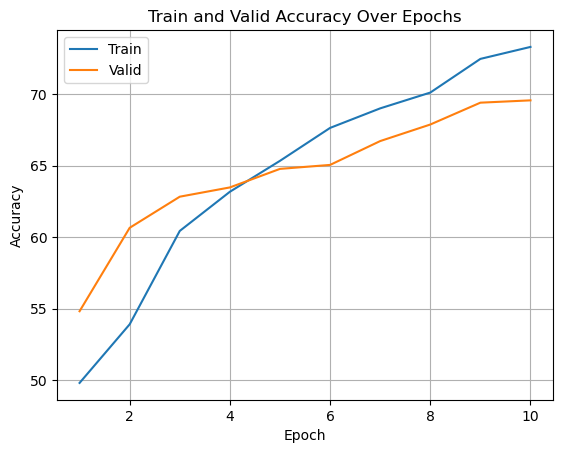

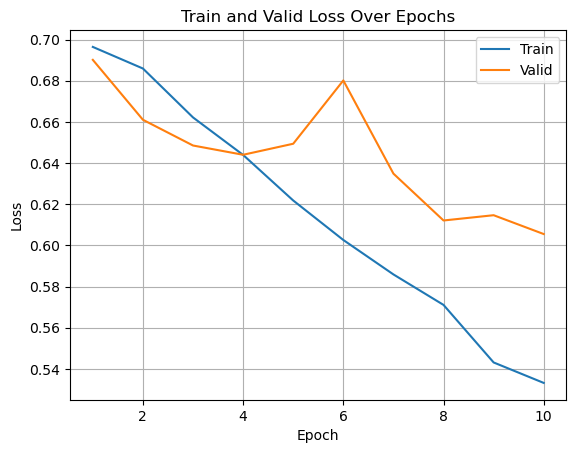

In [8]:
plot_data(train_accuracies, valid_accuracies, labels=['Train', 'Valid'], heading='Accuracy')
plot_data(train_losses, valid_losses, labels=['Train', 'Valid'], heading='Loss')

In [9]:
test(model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device)

Testing: 100%|██████████| 141/141 [00:49<00:00,  2.83it/s]

Test loss: 0.79
Test accuracy: 61.01%


In [10]:
# testwithstuff(model=model, 
#                 test_loader=test_loader, 
#                 device=device, 
#                 criterion=criterion)

In [11]:
# torch.save(model, "C:/Users/Jacqu/Downloads/model.pth")

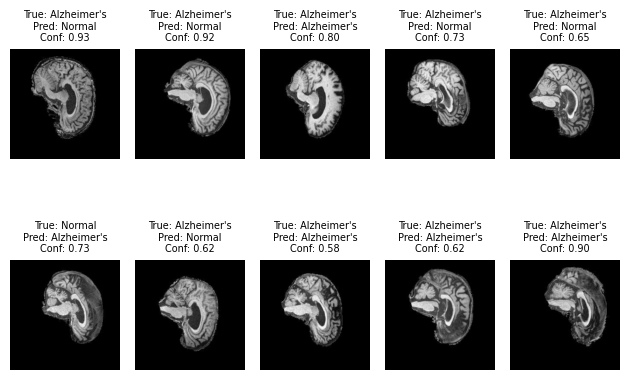

In [12]:
predict(model=model, 
        dataloader=test_loader, 
        device=device)